In [5]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path

In [6]:
mpl.rcParams['figure.figsize'] = (8, 8) # 8 inches by 8 inches
mpl.rcParams['axes.grid'] = False # No grid

In [7]:
pretrained_model = tf.keras.applications.MobileNetV2(weights='imagenet',
                                          include_top=True) # Load the model with ImageNet weights
pretrained_model.trainable = False # Freeze the model

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

In [8]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

In [17]:
##### test code ##########
#import tensorflow as tf

# URL of the file you want to download
url = "https://www.englishlampposts.co.uk/media/catalog/product/cache/99280adfeb2fd151a24c2907c39a5a80/v/i/victorian_lamp_post_lining_a_garden_edge.jpg"

# Use get_file to download the file
file_path = tf.keras.utils.get_file('victorian_lamp_post_lining_a_garden_edge.jpg', origin=url, cache_dir='.', cache_subdir='.')

print(f'File downloaded to: {file_path}')

Exception: URL fetch failure on https://www.englishlampposts.co.uk/media/catalog/product/cache/99280adfeb2fd151a24c2907c39a5a80/v/i/victorian_lamp_post_lining_a_garden_edge.jpg: 403 -- Forbidden

In [ ]:
import os
# File uploader in UI
uploaded_file = st.file_uploader("Upload an image", type=["jpg", "png", "jpeg"])
if uploaded_file is not None:
    # Save uploaded file locally
    file_path = os.path.join("temp_image.jpg")
    with open(file_path, "wb") as f:
        f.write(uploaded_file.getbuffer())
    # Load image using tf.keras.utils.get_file
    image_path = tf.keras.utils.get_file("user_uploaded_image", f"file://{os.path.abspath(file_path)}")
    st.image(image_path, caption="Uploaded Image", use_column_width=True)

In [15]:
#image_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')

image_path = tf.keras.utils.get_file(
    fname='giraffe.jpg', 
    origin="C:\Users\jeffb\Desktop\Bootcamp_repo\hemlock\resources\giraffe.jpg"
)

image_raw = tf.io.read_file(image_path) # reads the image file
image = tf.image.decode_image(image_raw) # decodes image tensor

image = preprocess(image) # custom preprocess function
image_probs = pretrained_model.predict(image) # returns a probability vector for the likelyhood of each class



SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (2669363626.py, line 6)

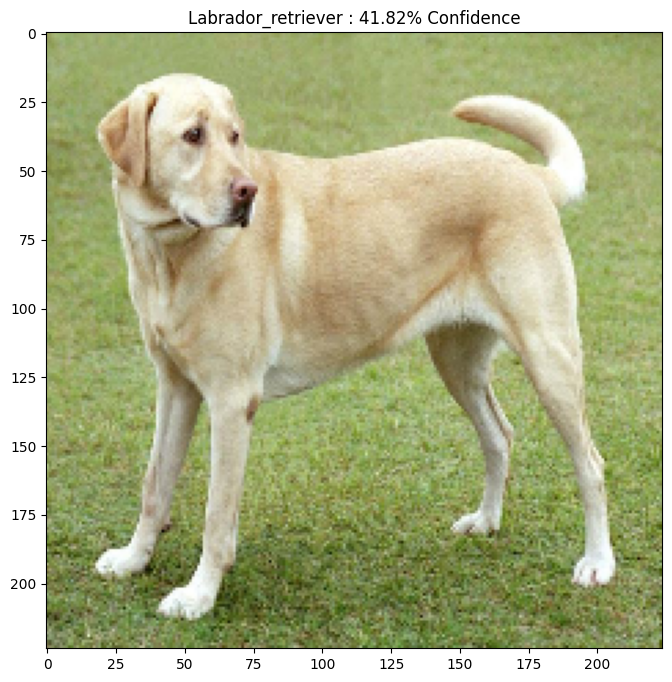

In [ ]:
plt.figure() 
plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
_, image_class, class_confidence = get_imagenet_label(image_probs) # Get the class label and confidence score
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100)) # determined image class and confidence
plt.show()

Create the adversarial image


Steven Frasica
  7:40 PM
tf.keras.losses is a module provided by TensorFlow that includes a set of loss functions, which are used to measure how well a machine learning model performs. These functions calculate the difference between the predicted outputs of the model and the actual outcomes (ground truth). The goal during training is to minimize this difference, thereby improving the model's predictions.

Loss Functions in tf.keras

Loss functions in TensorFlow Keras are available both as classes and as functions. Using the class form allows you to configure certain parameters when you instantiate the loss, such as whether to consider the logits (unnormalized predictions) or probabilities, and the label smoothing. The function form is a more direct way to compute the loss.

Here are some commonly used loss functions in tf.keras:

    BinaryCrossentropy: Used for binary classification tasks. It measures the difference between two probability distributions - the actual labels and the predicted labels.

    CategoricalCrossentropy: Used for multi-class classification tasks where the labels are one-hot encoded.

    SparseCategoricalCrossentropy: Similar to CategoricalCrossentropy but used when the labels are integers.

    MeanSquaredError: Commonly used for regression tasks. It computes the average of the squares of the differences between the predicted and actual values.

    CosineSimilarity: Measures the cosine of the angle between the predicted and actual values. It's often used in embedding models.

In [ ]:
loss_object = tf.keras.losses.CategoricalCrossentropy() # Loss function to be used for the adversarial attack

def create_adversarial_pattern(input_image, input_label): # Create adversarial pattern
  with tf.GradientTape() as tape: # GradientTape is used to record the operations for automatic differentiation
    tape.watch(input_image) # Watch the input image for gradients
    prediction = pretrained_model(input_image) # Get the model prediction for the input image
    loss = loss_object(input_label, prediction) # Calculate the loss between the predicted and true label

  
  gradient = tape.gradient(loss, input_image) # Get the gradients of the loss w.r.t to the input image.
  signed_grad = tf.sign(gradient) # Sign of the gradient is used to create the perturbation
  return signed_grad

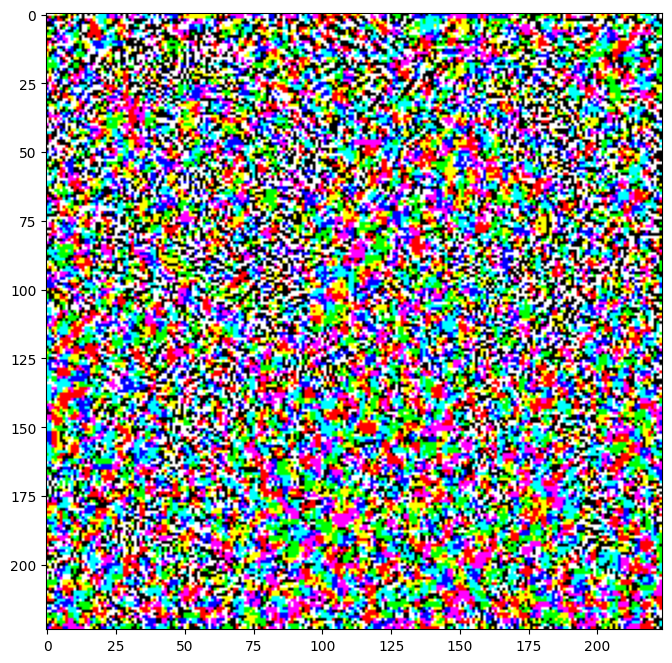

In [ ]:
# Get the input label of the image.
labrador_retriever_index = 208 # Index of the label in the ImageNet dataset
label = tf.one_hot(labrador_retriever_index, image_probs.shape[-1]) # One-hot encoding of the label
label = tf.reshape(label, (1, image_probs.shape[-1])) # Reshape the label to match the input shape of the model

perturbations = create_adversarial_pattern(image, label) # Create the perturbations using the adversarial pattern function
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

In [ ]:
def display_images(image, description): # Function to display the images
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image)) # Get the label and confidence of the image
  plt.figure()
  plt.imshow(image[0]*0.5+0.5) # To change [-1, 1] to [0,1]
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100)) # Display the image with the label and confidence
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


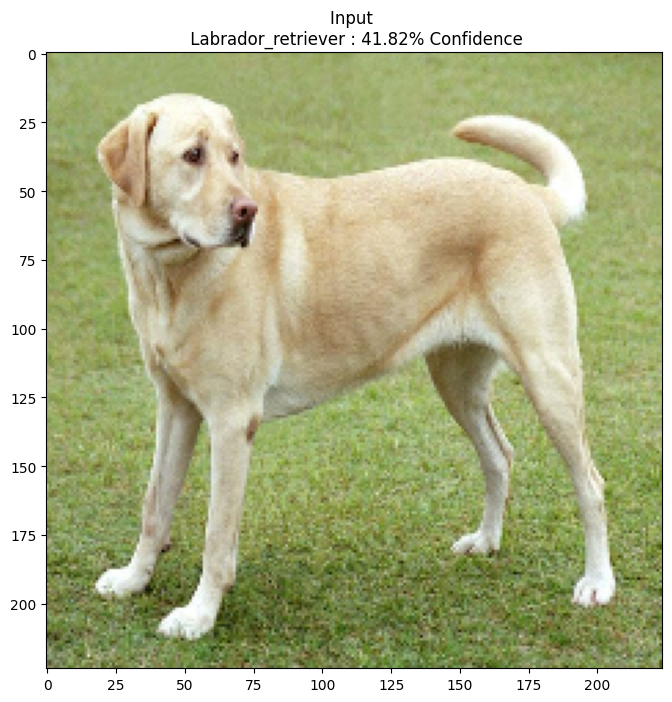

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


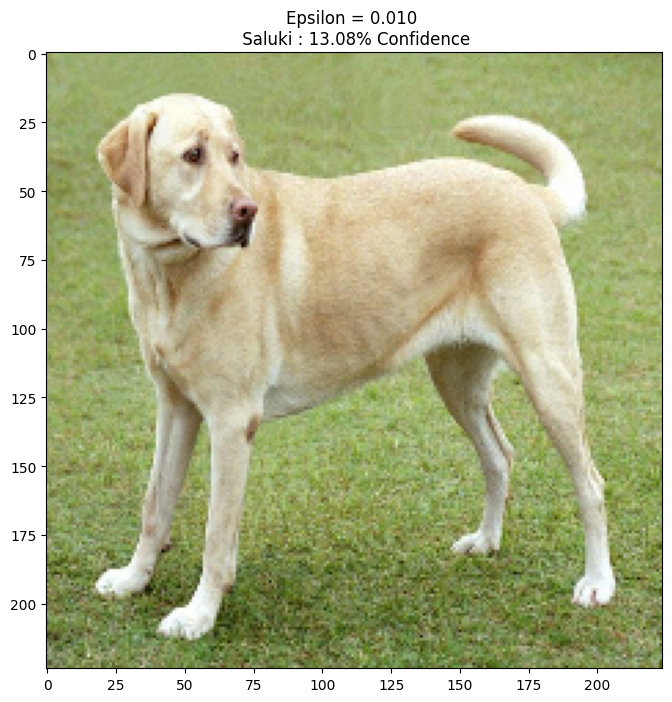

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


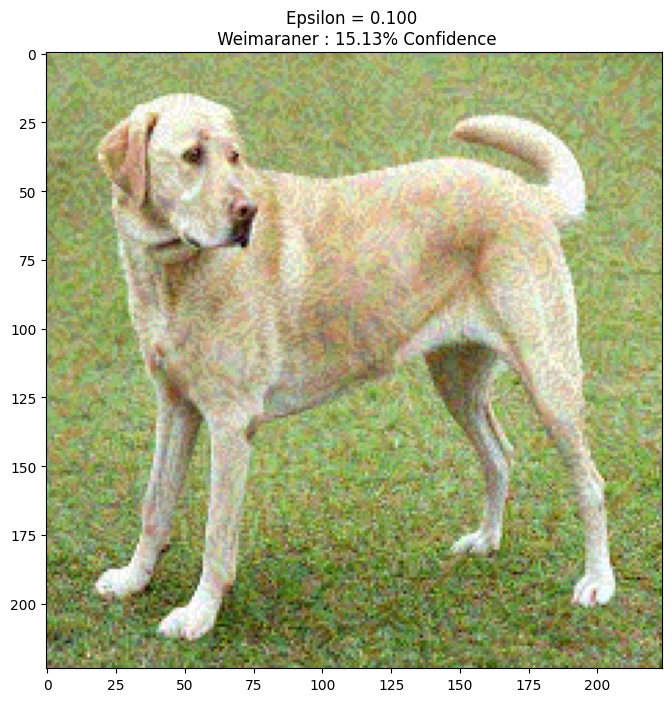

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


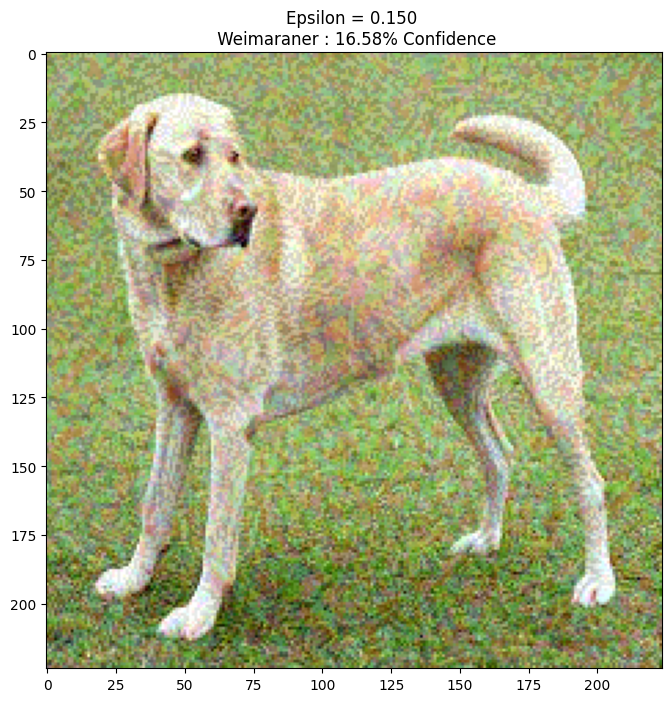

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


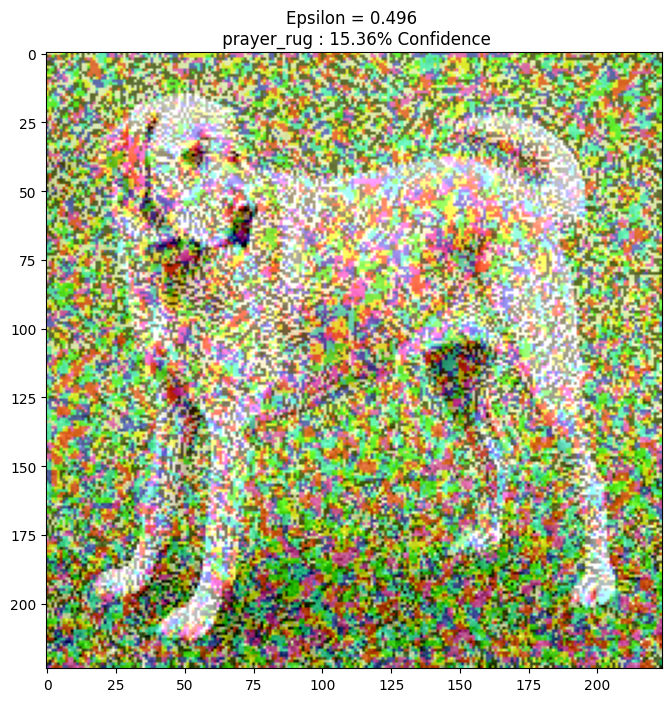

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


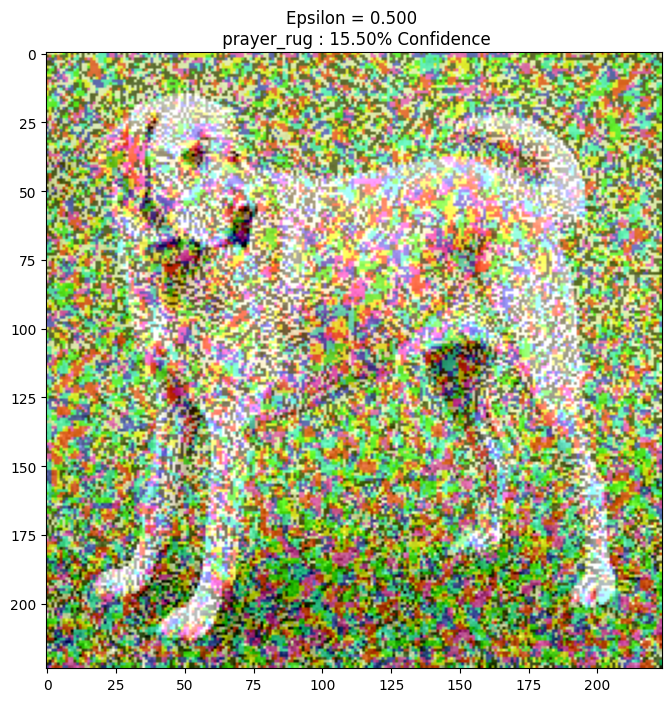

In [ ]:
epsilons = [0, 0.01, 0.1, 0.15, 0.4962, 0.5] # Epsilon values for the perturbations
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons] # Create descriptions for the images

for i, eps in enumerate(epsilons): # Loop through the epsilon values
  adv_x = image + eps*perturbations # Create the adversarial image by adding the perturbations to the original image
  adv_x = tf.clip_by_value(adv_x, -1, 1) # Clip the values to be in the range [-1, 1]
  display_images(adv_x, descriptions[i]) # Display the images with the perturbations